In [1]:
import tensorflow as tf
import keras
import vis ## keras-vis
import matplotlib.pyplot as plt
import numpy as np
print("keras      {}".format(keras.__version__))
print("tensorflow {}".format(tf.__version__))

Using TensorFlow backend.


keras      2.2.4
tensorflow 1.15.0


For reference please visit the blog
https://fairyonice.github.io/Grad-CAM-with-keras-vis.html

In [2]:
from keras.applications.vgg16 import VGG16, preprocess_input
model = VGG16(weights='imagenet')
model.summary()
for ilayer, layer in enumerate(model.layers):
    print("{:3.0f} {:10}".format(ilayer, layer.name))

W0102 17:43:52.217417 17668 module_wrapper.py:139] From C:\Users\tamohant\AppData\Local\Continuum\anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0102 17:43:52.223401 17668 module_wrapper.py:139] From C:\Users\tamohant\AppData\Local\Continuum\anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:529: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0102 17:43:52.227393 17668 module_wrapper.py:139] From C:\Users\tamohant\AppData\Local\Continuum\anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4412: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0102 17:43:52.282267 17668 module_wrapper.py:139] From C:\Users\tamohant\AppData\Local\Continuum\anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4247: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d i

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [3]:
import json
CLASS_INDEX = json.load(open("imagenet_class_index.json"))
classlabel  = []
for i_dict in range(len(CLASS_INDEX)):
    classlabel.append(CLASS_INDEX[str(i_dict)][1])
print("N of class={}".format(len(classlabel)))

N of class=1000


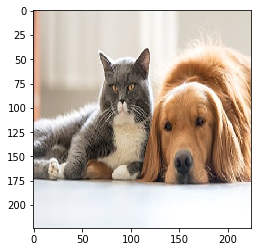

In [4]:
from keras.preprocessing.image import load_img, img_to_array
#_img = load_img("duck.jpg",target_size=(224,224))
_img = load_img("dog_and_cat.jpg",target_size=(224,224))
plt.imshow(_img)
plt.show()

In [5]:
img               = img_to_array(_img)
img               = preprocess_input(img)
y_pred            = model.predict(img[np.newaxis,...])
class_idxs_sorted = np.argsort(y_pred.flatten())[::-1]
topNclass         = 5
for i, idx in enumerate(class_idxs_sorted[:topNclass]):
    print("Top {} predicted class:     Pr(Class={:18} [index={}])={:5.3f}".format(
          i + 1,classlabel[idx],idx,y_pred[0,idx]))

Top 1 predicted class:     Pr(Class=Tibetan_mastiff    [index=244])=0.063
Top 2 predicted class:     Pr(Class=tiger_cat          [index=282])=0.055
Top 3 predicted class:     Pr(Class=tennis_ball        [index=852])=0.048
Top 4 predicted class:     Pr(Class=golden_retriever   [index=207])=0.045
Top 5 predicted class:     Pr(Class=collie             [index=231])=0.039


In [6]:
from vis.utils import utils
# Utility to search for layer index by name. 
# Alternatively we can specify this as -1 since it corresponds to the last layer.
layer_idx = utils.find_layer_idx(model, 'predictions')
# Swap softmax with linear
model.layers[layer_idx].activation = keras.activations.linear
model = utils.apply_modifications(model)

C:\Users\tamohant\AppData\Local\Continuum\anaconda3\lib\site-packages\keras\engine\saving.py:308: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [7]:
from vis.visualization import visualize_cam
penultimate_layer_idx = utils.find_layer_idx(model, "block5_conv3") 
class_idx  = class_idxs_sorted[0]
seed_input = img
grad_top1  = visualize_cam(model, layer_idx, class_idx, seed_input, 
                           penultimate_layer_idx = penultimate_layer_idx,#None,
                           backprop_modifier     = None,
                           grad_modifier         = None)

W0102 17:44:25.855337 17668 module_wrapper.py:139] From C:\Users\tamohant\AppData\Local\Continuum\anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:136: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.



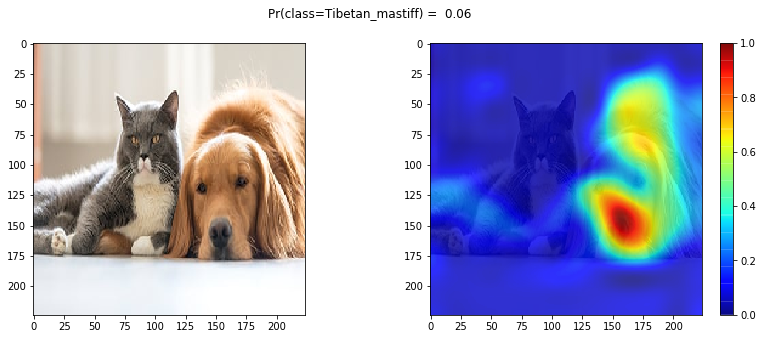

In [8]:
def plot_map(grads):
    fig, axes = plt.subplots(1,2,figsize=(14,5))
    axes[0].imshow(_img)
    axes[1].imshow(_img)
    i = axes[1].imshow(grads,cmap="jet",alpha=0.8)
    fig.colorbar(i)
    plt.suptitle("Pr(class={}) = {:5.2f}".format(
                      classlabel[class_idx],
                      y_pred[0,class_idx]))
plot_map(grad_top1)

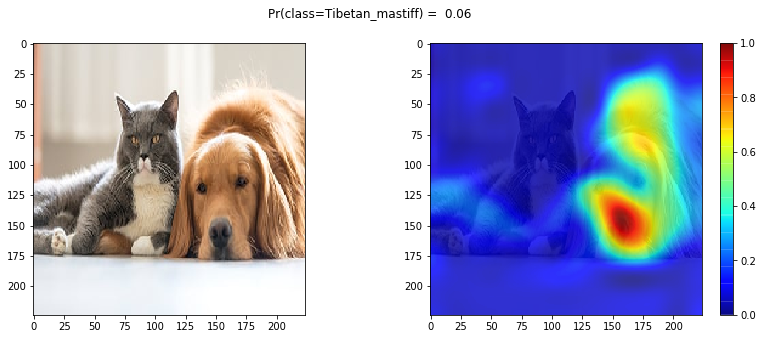

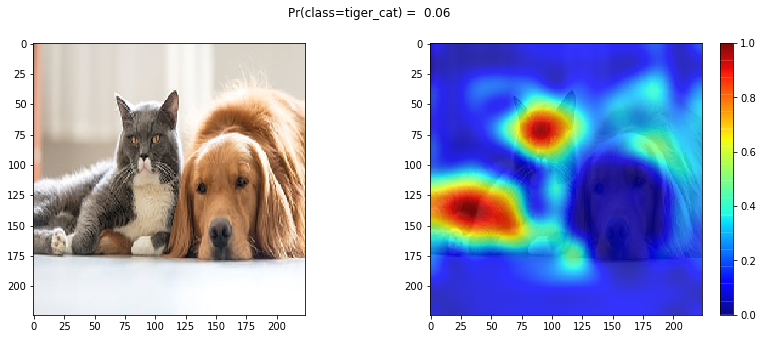

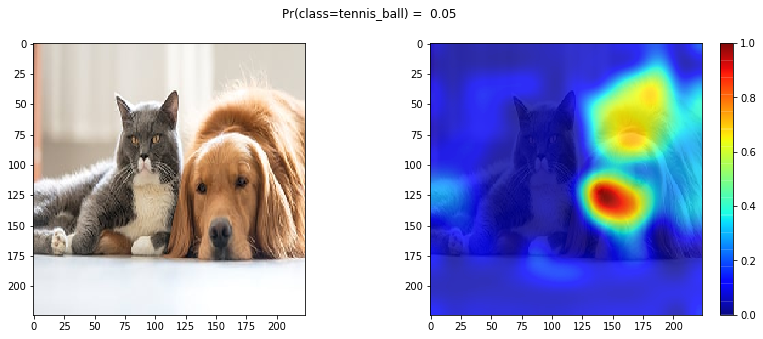

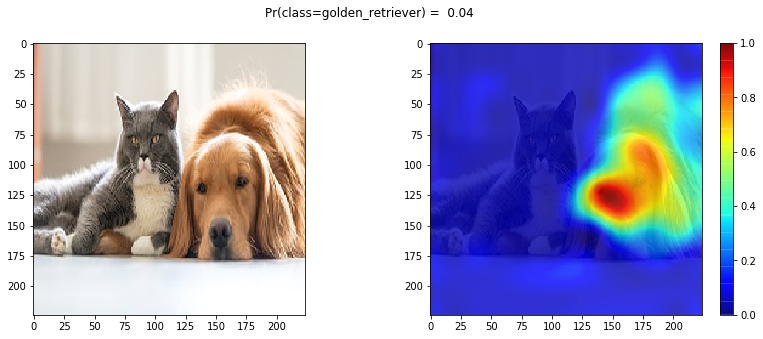

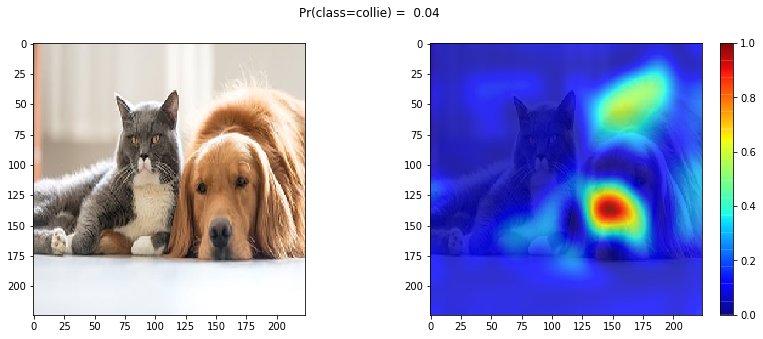

In [9]:
for class_idx in class_idxs_sorted[:topNclass]:
    grads  = visualize_cam(model,layer_idx,class_idx, seed_input,
                           penultimate_layer_idx = penultimate_layer_idx,
                           backprop_modifier     = None,
                           grad_modifier         = None)
    plot_map(grads)

In [10]:
import keras.backend as K
from scipy.ndimage.interpolation import zoom
## select class of interest
class_idx           = class_idxs_sorted[0]
## feature map from the final convolusional layer
final_fmap_index    = utils.find_layer_idx(model, 'block5_conv3')
penultimate_output  = model.layers[final_fmap_index].output

## define derivative d loss^c / d A^k,k =1,...,512
layer_input          = model.input
## This model must already use linear activation for the final layer
loss                 = model.layers[layer_idx].output[...,class_idx]
grad_wrt_fmap        = K.gradients(loss,penultimate_output)[0]

## create function that evaluate the gradient for a given input
# This function accept numpy array
grad_wrt_fmap_fn     = K.function([layer_input,K.learning_phase()],
                                  [penultimate_output,grad_wrt_fmap])

## evaluate the derivative_fn
fmap_eval, grad_wrt_fmap_eval = grad_wrt_fmap_fn([img[np.newaxis,...],0])

# For numerical stability. Very small grad values along with small penultimate_output_value can cause
# w * penultimate_output_value to zero out, even for reasonable fp precision of float32.
grad_wrt_fmap_eval /= (np.max(grad_wrt_fmap_eval) + K.epsilon())

print(grad_wrt_fmap_eval.shape)
alpha_k_c           = grad_wrt_fmap_eval.mean(axis=(0,1,2)).reshape((1,1,1,-1))
Lc_Grad_CAM         = np.maximum(np.sum(fmap_eval*alpha_k_c,axis=-1),0).squeeze()

## upsampling the class activation map to th esize of ht input image
scale_factor        = np.array(img.shape[:-1])/np.array(Lc_Grad_CAM.shape)
_grad_CAM           = zoom(Lc_Grad_CAM,scale_factor)
## normalize to range between 0 and 1
arr_min, arr_max    = np.min(_grad_CAM), np.max(_grad_CAM)
grad_CAM            = (_grad_CAM - arr_min) / (arr_max - arr_min + K.epsilon())

(1, 14, 14, 512)


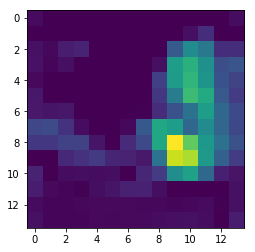

In [11]:
plt.imshow(Lc_Grad_CAM)
plt.show()

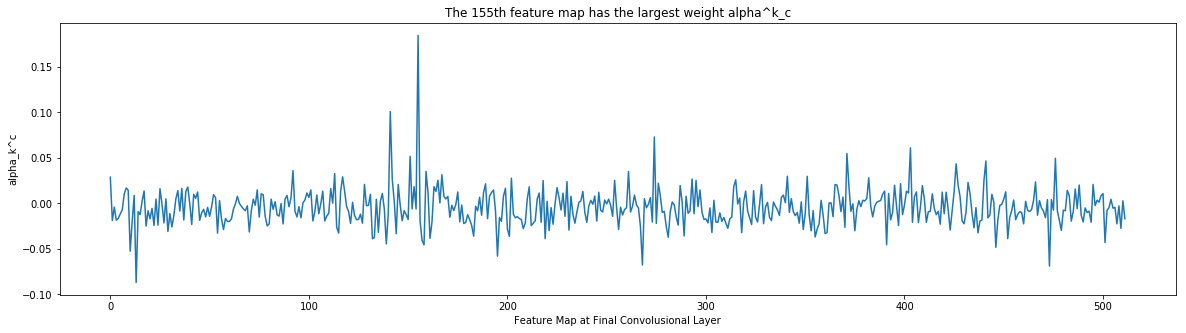

In [12]:
plt.figure(figsize=(20,5))
plt.plot(alpha_k_c.flatten())
plt.xlabel("Feature Map at Final Convolusional Layer")
plt.ylabel("alpha_k^c")
plt.title("The {}th feature map has the largest weight alpha^k_c".format(
    np.argmax(alpha_k_c.flatten())))
plt.show()

W0102 17:45:00.613068 17668 deprecation.py:323] From C:\Users\tamohant\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow_core\python\ops\math_grad.py:1375: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Iteration: 1, named_losses: [('ActivationMax Loss', -0.4966106),
 ('L-6.0 Norm Loss', 0.06325796),
 ('TV(2.0) Loss', 6440.5527)], overall loss: 6440.119140625
Iteration: 2, named_losses: [('ActivationMax Loss', -0.7636614),
 ('L-6.0 Norm Loss', 0.06268536),
 ('TV(2.0) Loss', 3412.9602)], overall loss: 3412.25927734375
Iteration: 3, named_losses: [('ActivationMax Loss', -1.9216517),
 ('L-6.0 Norm Loss', 0.062347278),
 ('TV(2.0) Loss', 1872.8871)], overall loss: 1871.02783203125
Iteration: 4, named_losses: [('ActivationMax Loss', -3.935995),
 ('L-6.0 Norm Loss', 0.062128328),
 ('TV(2.0) Loss', 996.78625)], overall loss: 992.9124145507812
Iteration: 5, named_losses: [('ActivationMax Loss', -5.7936335),
 ('L-6.0 Norm Loss', 0.061984405),
 ('TV(2.0) Loss', 489.61783)], overall loss: 483.88616943359375
Iteration: 6, named_losses: [('ActivationMax Loss', -7.098025),
 ('L-6.0 Norm Loss', 0.061891004),
 ('TV(2.0) Loss', 208.09941)], overall loss: 201.0632781982422
Iteration: 7, named_losses: [(

Iteration: 52, named_losses: [('ActivationMax Loss', -46.130775),
 ('L-6.0 Norm Loss', 0.06185131),
 ('TV(2.0) Loss', 32.241505)], overall loss: -13.82741928100586
Iteration: 53, named_losses: [('ActivationMax Loss', -48.10319),
 ('L-6.0 Norm Loss', 0.06185311),
 ('TV(2.0) Loss', 32.9062)], overall loss: -15.135139465332031
Iteration: 54, named_losses: [('ActivationMax Loss', -48.152885),
 ('L-6.0 Norm Loss', 0.061854195),
 ('TV(2.0) Loss', 33.03337)], overall loss: -15.057659149169922
Iteration: 55, named_losses: [('ActivationMax Loss', -48.09953),
 ('L-6.0 Norm Loss', 0.061856102),
 ('TV(2.0) Loss', 33.744064)], overall loss: -14.293609619140625
Iteration: 56, named_losses: [('ActivationMax Loss', -48.44783),
 ('L-6.0 Norm Loss', 0.061857466),
 ('TV(2.0) Loss', 32.51191)], overall loss: -15.874061584472656
Iteration: 57, named_losses: [('ActivationMax Loss', -48.067806),
 ('L-6.0 Norm Loss', 0.061859332),
 ('TV(2.0) Loss', 32.651775)], overall loss: -15.354171752929688
Iteration: 58,

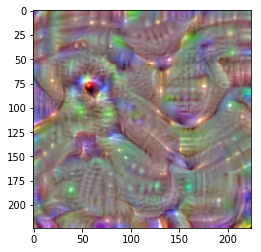

In [13]:
from vis.visualization import visualize_activation
activation_max = visualize_activation(model, 
                                      layer_idx      = final_fmap_index, 
                                      max_iter       = 100,
                                      verbose        = True,
                                      filter_indices = 155)
print(activation_max.shape)
plt.imshow(activation_max)
plt.show()

In [14]:
assert np.all(np.abs(grad_CAM  - grad_top1) < 0.0001)

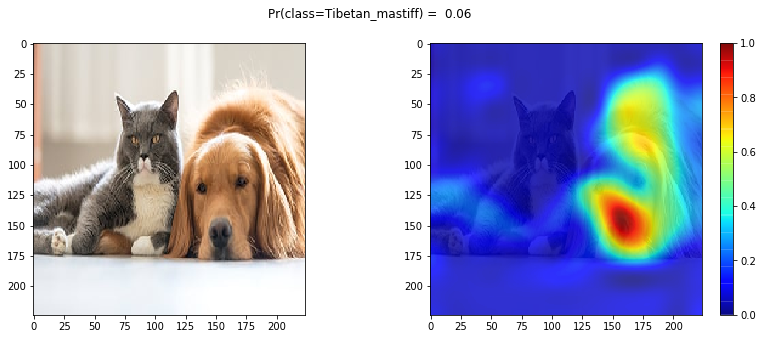

In [15]:
plot_map(grad_CAM)